In [1]:
import os
from tqdm import tqdm
from deepface.commons import functions
from elasticsearch import Elasticsearch
import matplotlib.pyplot as plt
import random
import time

Using TensorFlow backend.


In [2]:
backend = 'Facenet'

In [3]:
print("Backend is ", backend)

if backend == 'Facenet':
    from deepface.basemodels import Facenet
    model = Facenet.loadModel()
    target_size = (160, 160)
    embedding_size = 128

elif backend == 'Dlib':
    from deepface.basemodels.DlibResNet import DlibResNet
    model = DlibResNet()
    target_size = (150, 150)
    embedding_size = 128

Backend is  Facenet


In [4]:
es = Elasticsearch([{'host': 'localhost', 'port': '9200'}])

In [5]:
mapping = {
    "mappings": {
        "properties": {
            "title_vector":{
                "type": "dense_vector",
                "dims": embedding_size
            },
            "title_name": {"type": "keyword"}
        }
    }
}
   
es.indices.create(index="face_recognition", body=mapping)

{'acknowledged': True,
 'index': 'face_recognition',
 'shards_acknowledged': True}

In [6]:
files = []
for r, d, f in os.walk("deepface/tests/dataset/"):
    for file in f:
        if ('.jpg' in file):
            exact_path = r + file
            files.append(exact_path)

In [7]:
tic = time.time()
index = 0
for img_path in files:
    #print(img_path)
    img = functions.preprocess_face(img_path, target_size = target_size)
    embedding = model.predict(img)[0]
    
    doc = {"title_vector": embedding, "title_name": img_path}
    es.create("face_recognition", id=index, body=doc)
    
    index = index + 1

toc = time.time()
print("indexing completed in ",toc-tic," seconds")

indexing completed in  48.1922562122345  seconds


In [8]:
len(files)

61

# Synthetic data

In [ ]:
"""for i in tqdm(range(len(files), 100000), desc='Creating synthetic data'):
    img_path = 'deepface/tests/dataset/synthetic_%d.jpg' % (i)
    embedding = [random.gauss(-2.280426, 2.4555223) for z in range(embedding_size)]
    
    doc = {"title_vector": embedding, "title_name": img_path}
    es.create("face_recognition", id=index, body=doc)
    index = index + 1"""

# Target

In [9]:
target_path = "target.jpg"
target_img = functions.preprocess_face(target_path, target_size = target_size)
target_embedding = model.predict(target_img)[0]

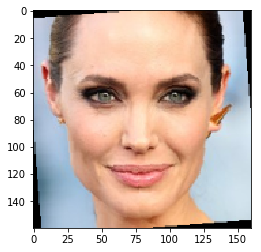

In [12]:
plt.imshow(target_img[0][:,:,::-1])

In [23]:
query = {
    "size": 5,
    "query": {
    "script_score": {
        "query": {
            "match_all": {}
        },
        "script": {
            #"source": "cosineSimilarity(params.queryVector, 'title_vector') + 1.0",
            "source": "1 / (1 + l2norm(params.queryVector, 'title_vector'))", #euclidean distance
            "params": {
                "queryVector": list(target_embedding)
            }
        }
    }
}}

In [24]:
tic = time.time()
res = es.search(index="face_recognition", body=query)
toc = time.time()

print(toc-tic," seconds")

0.007018566131591797  seconds


deepface/tests/dataset/img6.jpg . Score:  0.13597088


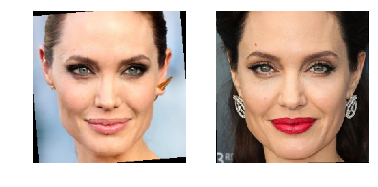

-------------------------
deepface/tests/dataset/img7.jpg . Score:  0.13213713


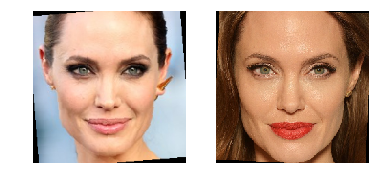

-------------------------
deepface/tests/dataset/img10.jpg . Score:  0.12267026


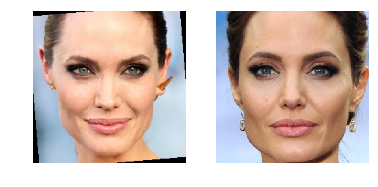

-------------------------
deepface/tests/dataset/img2.jpg . Score:  0.121122286


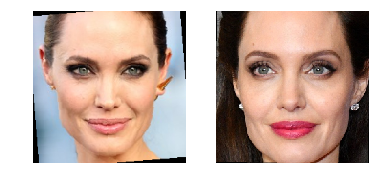

-------------------------
deepface/tests/dataset/img1.jpg . Score:  0.11378789


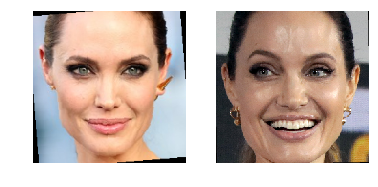

-------------------------


In [27]:
for i in res["hits"]["hits"]:
    candidate_name = i["_source"]["title_name"]
    candidate_score = i["_score"]
    print(candidate_name, ". Score: ", candidate_score)
    
    candidate_img = functions.preprocess_face(candidate_name)[0]
    
    fig = plt.figure()
    
    ax1 = fig.add_subplot(1, 2, 1)
    plt.imshow(target_img[0][:,:,::-1])
    plt.axis('off')
    
    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(candidate_img[:,:,::-1])
    plt.axis('off')
    
    plt.show()
    
    print("-------------------------")